# NLP and Reddit Subcommunities - Modeling
---

In this notebook, our objective is to build models that can accurately classify the subreddit from which a given post originates. To achieve this, we will employ pipelines, grid-searching (GridSearchCV) and randomized-searching (RandomizedSearchCV), and iterating through different hyperparameters to evaluate the performance of various machine learning algorithms. Our focus will be on testing classification models such as Logistic Regression, Multinomial Naive Bayes, and Support Vector Machines. Additionally, we will address the challenges of overfitting and underfitting by considering approaches like Random Forest and Gradient Boosting, respectively.

1. <s>Linear Regression <u>**Without**</u> Log-Transformed Target Variable</s>
2. <s>Linear Regression <u>**With**</u> Log-Transformed Target Variable</s>
3. <s>Linear Regression <u>**With**</u> Log-Transformed Target Variable and RidgeCV Regularization</s>
4. <s>Linear Regression <u>**With**</u> Log-Transformed Target Variable and LassoCV Regularization</s>

For more information on the initial data cleaning, exploration, and visualization see the [initial notebook](../code/01_EDA_and_Cleaning.ipynb) of this analysis. For transforming our variables into model-ready form, see the [second notebook](../code/02_Feature_Engineering.ipynb) of this analysis.

For more information on the background, [data](https://jse.amstat.org/v19n3/decock/DataDocumentation.txt), and a summary of methods and findings, please see the associated [README](../Farah_Malik_Proj2_README.md) for this analysis.

### Contents:
- [I. Model Building and Testing](#I.-Model-Building-and-Testing)
    - [Sales Price - Not Log Transformed](#Modeling-Sale-Price-Modeling-(Not-Log-Transformed))
    - [Sales Price - Log Transformed](#Modeling-Sale-Price-Modeling-(Log-Transformed))
- [II. Regularization](#II.-Regularization)
    - [Ridge CV](#Ridge-CV)
    - [Lasso CV](#Lasso-CV)
---

In [ ]:
import warnings
warnings.filterwarnings('ignore') # Notebook was run with warnings enabled and significant ones have been addressed, remaining warnings were insignificant and have been suppressed

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, roc_auc_score
from sklearn.svm import LinearSVC, SVC
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [2]:
snowski = pd.read_csv('../data/Clean/snow_ski2.csv')
snowski.head()

,created_utc,author,score,upvote_ratio,num_comments,subreddit,text,lem_text,stem_text,post_length,post_word_count
0,1.686844e+09,bas1cred,26,0.91,19,snowboardingnoobs,my first board. ready for the upcoming season!!,my first board ready for the upcoming season,my first board readi for the upcom season,48,8
1,1.686786e+09,Pooffios,3,1.00,12,snowboardingnoobs,"outer side foot pain hi all, i was hoping to g...",outer side foot pain hi all i wa hoping to get...,outer side foot pain hi all i wa hope to get s...,301,60
2,1.686781e+09,trips69420,2,0.75,15,snowboardingnoobs,first board? looking to probably grab this as ...,first board looking to probably grab this a my...,first board look to probabl grab thi as my fir...,274,53
3,1.686779e+09,twinbee,11,0.87,0,snowboardingnoobs,i did a front-side 180 today! more than one in...,i did a front side 180 today more than one in ...,i did a front side 180 today more than one in ...,1565,289
4,1.686767e+09,Madden_Stephen,2,0.67,24,snowboardingnoobs,step-on boot recommendation? i’ve done a decen...,step on boot recommendation i ve done a decent...,step on boot recommend i ve done a decent bit ...,686,122


In [3]:
# Define baseline
snowski.subreddit.value_counts(normalize=True)

# Our model must have an accuracy score > 51.2% in order to be useful

skiing               0.51242
snowboardingnoobs    0.48758
Name: subreddit, dtype: float64

In [4]:
snowski['subreddit'] = snowski['subreddit'].map({'snowboardingnoobs': 1, 'skiing': 0})
snowski.head()

,created_utc,author,score,upvote_ratio,num_comments,subreddit,text,lem_text,stem_text,post_length,post_word_count
0,1.686844e+09,bas1cred,26,0.91,19,1,my first board. ready for the upcoming season!!,my first board ready for the upcoming season,my first board readi for the upcom season,48,8
1,1.686786e+09,Pooffios,3,1.00,12,1,"outer side foot pain hi all, i was hoping to g...",outer side foot pain hi all i wa hoping to get...,outer side foot pain hi all i wa hope to get s...,301,60
2,1.686781e+09,trips69420,2,0.75,15,1,first board? looking to probably grab this as ...,first board looking to probably grab this a my...,first board look to probabl grab thi as my fir...,274,53
3,1.686779e+09,twinbee,11,0.87,0,1,i did a front-side 180 today! more than one in...,i did a front side 180 today more than one in ...,i did a front side 180 today more than one in ...,1565,289
4,1.686767e+09,Madden_Stephen,2,0.67,24,1,step-on boot recommendation? i’ve done a decen...,step on boot recommendation i ve done a decent...,step on boot recommend i ve done a decent bit ...,686,122


---
## I. Pre-Processing Functions
Note: Functions were generated and tested, but not all are used as final parameters in any of our models. The models were also run using "lem_text" and "stem_text" as target variables directly, but did not have any impact. 

---

In [5]:
# Function for Lemmatizing
def lemmatize_txt(text):
    
    tokenizer = RegexpTokenizer('\w+')
    split_txt = tokenizer.tokenize(text)

    # Instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
        
    # Lemmatize and Rejoin
    return ' '.join([lemmatizer.lemmatize(word) for word in split_txt])

In [6]:
# Function for Stemming
def stem_txt(text):
    
    tokenizer = RegexpTokenizer('\w+')
    split_txt = tokenizer.tokenize(text)

    # Instantiate Stemmer
    p_stemmer = PorterStemmer()

    # Stem and Rejoin
    return ' '.join([p_stemmer.stem(word) for word in split_txt])

In [7]:
X = snowski['text']
y = snowski['subreddit']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1527) 

---
## II. Model-Building and Testing
---

### Pipelines and GridSearch / RandomizedSearch

#### Model 1: Logistic Regression

In [30]:
# Create pipeline that tests b/t CVEC and TVEC transformers and an estimator
pipe_log = Pipeline([
                 ('vec', None),
                 ('logr', LogisticRegression(solver = 'liblinear', max_iter=1000))])

In [11]:
# Define hyperparameters
pgrid_logr =[
    {
    'vec': [CountVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 9000], 
    #'vec__min_df': [3, 5],
    #'vec__max_df': [0.9, 0.95],
    #'vec__preprocessor': [None, lemmatize_txt, stem_txt],
    'logr__C': np.linspace(.05,5.0,10),
    'logr__penalty': ['l1', 'l2']
    },
    {
    'vec': [TfidfVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 9000], 
    #'vec__min_df': [3, 5],
    #'vec__max_df': [0.9, 0.95],
    #'vec__preprocessor': [None, lemmatize_txt,stem_txt],
    'logr__C': np.linspace(.05,10.0,15),
    'logr__penalty': ['l1', 'l2']
    }
]

In [12]:
%%time

# Fit model via GridSearch
gs_log = GridSearchCV(pipe_log, pgrid_logr, cv=5)
gs_log.fit(X_train, y_train)

C:\Users\farah\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\farah\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\farah\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\farah\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\farah\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\farah\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

CPU times: total: 3min 32s
Wall time: 22min 54s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', None),
                                       ('logr',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             param_grid=[{'logr__C': array([0.05, 0.6 , 1.15, 1.7 , 2.25, 2.8 , 3.35, 3.9 , 4.45, 5.  ]),
                          'logr__penalty': ['l1', 'l2'],
                          'vec': [CountVectorizer()],
                          'vec__max_features': [7000, 9000],
                          'vec__stop_words': [None, 'english']},
                         {'logr__C': array([ 0.05      ,  0.76071429,  1.47142857,  2.18214286,  2.89285714,
        3.60357143,  4.31428571,  5.025     ,  5.73571429,  6.44642857,
        7.15714286,  7.86785714,  8.57857143,  9.28928571, 10.        ]),
                          'logr__penalty': ['l1', 'l2'],
                          'vec': [TfidfVectorizer(max_features=7000,
                                                  stop_words='english')],
                          'vec__max_features': [7000, 9000],
                          'vec__stop_words': [None, 'english']}])

In [93]:
# Make predictions for Accuracy Report
preds_log = gs_log.predict(X_test)

In [48]:
print(f'--------- Logistic Regression w/ GridSearch ---------')
print(f'------------- Train: {gs_log.score(X_train, y_train)} -------------')
print(f'------------- Test: {gs_log.score(X_test, y_test)} -------------')
print('Best Params:', gs_log.best_params_)

--------- Logistic Regression w/ GridSearch ---------
------------- Train: 0.9550508634965696 -------------
------------- Test: 0.879347054648687 -------------
Best Params: {'logr__C': 2.182142857142857, 'logr__penalty': 'l2', 'vec': TfidfVectorizer(max_features=9000), 'vec__max_features': 7000, 'vec__stop_words': 'english'}


In [97]:
%%time

# Test RandomizedSearch for comparison in timing and outcome
rs_log = RandomizedSearchCV(pipe_log, pgrid_logr, cv=5, n_iter=10, random_state=1527)
rs_log.fit(X_train, y_train)

CPU times: total: 1.86 s
Wall time: 7.67 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vec', None),
                                             ('logr',
                                              LogisticRegression(max_iter=1000,
                                                                 solver='liblinear'))]),
                   param_distributions=[{'logr__C': array([0.05, 0.6 , 1.15, 1.7 , 2.25, 2.8 , 3.35, 3.9 , 4.45, 5.  ]),
                                         'logr__penalty': ['l1', 'l2'],
                                         'vec': [CountVectorizer()],
                                         'vec__max_features': [7000, 9000],
                                         'vec__stop_words': [None, 'english']},
                                        {'logr__C': array([ 0.05      ,  0.76071429,  1.47142857,  2.18214286,  2.89285714,
        3.60357143,  4.31428571,  5.025     ,  5.73571429,  6.44642857,
        7.15714286,  7.86785714,  8.57857143,  9.28928571, 10.        ]),
                                         'logr__penalty': ['l1', 'l2'],
                                         'vec': [TfidfVectorizer(max_features=7000)],
                                         'vec__max_features': [7000, 9000],
                                         'vec__stop_words': [None, 'english']}],
                   random_state=1527)

In [98]:
preds_log_r = rs_log.predict(X_test)

In [99]:
print(f'------ Logistic Regression w/ RandomizedSearch ------')
print(f'------------- Train: {rs_log.score(X_train, y_train)} -------------')
print(f'------------- Test: {rs_log.score(X_test, y_test)} --------------')
print('Best Params:', rs_log.best_params_)

# Randomized search computed faster and test score is slightly better - we will utilize RS more

------ Logistic Regression w/ RandomizedSearch ------
------------- Train: 0.9744499645138396 -------------
------------- Test: 0.8807665010645848 -------------
Best Params: {'vec__stop_words': None, 'vec__max_features': 7000, 'vec': TfidfVectorizer(max_features=7000), 'logr__penalty': 'l2', 'logr__C': 5.0249999999999995}


#### Model 2: Multinomial Naive Bayes

In [54]:
pipe_nb = Pipeline([
    ('vec', None),
    ('nb', MultinomialNB())
])

In [55]:
pgrid_nb =[
    {
    'vec': [CountVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 9000], 
    #'vec__min_df': [3, 5],
    'vec__max_df': [0.9, 0.95],
    #'vec__preprocessor': [None, lemmatize_txt, stem_txt],
    'nb__alpha': [.01, 0.5, 1.0, 5.0]
    },
    {
    'vec': [TfidfVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 9000], 
    #'vec__min_df': [3, 5],
    'vec__max_df': [0.9, 0.95],
    #'vec__preprocessor': [None, lemmatize_txt,stem_txt],
    'nb__alpha': [.01, 0.5, 1.0, 5.0]
    }
]

In [56]:
%%time

gs_nb = GridSearchCV(pipe_nb, pgrid_nb, cv=5)
gs_nb.fit(X_train, y_train)

CPU times: total: 7.77 s
Wall time: 43.3 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', None), ('nb', MultinomialNB())]),
             param_grid=[{'nb__alpha': [0.01, 0.5, 1.0, 5.0],
                          'vec': [CountVectorizer(max_df=0.9,
                                                  max_features=7000)],
                          'vec__max_df': [0.9, 0.95],
                          'vec__max_features': [7000, 9000],
                          'vec__stop_words': [None, 'english']},
                         {'nb__alpha': [0.01, 0.5, 1.0, 5.0],
                          'vec': [TfidfVectorizer()],
                          'vec__max_df': [0.9, 0.95],
                          'vec__max_features': [7000, 9000],
                          'vec__stop_words': [None, 'english']}])

In [58]:
# Make predictions for Accuracy Report
preds_nb = gs_nb.predict(X_test)

In [57]:
print(f'---------- Multinomial Bayes w/ GridSearch ----------')
print(f'------------- Train: {gs_nb.score(X_train, y_train)} -------------')
print(f'------------- Test: {gs_nb.score(X_test, y_test)} -------------')
print('Best Params:', gs_nb.best_params_)

---------- Multinomial Bayes w/ GridSearch ----------
------------- Train: 0.907735982966643 -------------
------------- Test: 0.8559261887863733 -------------
Best Params: {'nb__alpha': 0.5, 'vec': CountVectorizer(max_df=0.9, max_features=7000), 'vec__max_df': 0.9, 'vec__max_features': 7000, 'vec__stop_words': None}


In [100]:
%%time

# Test RandomizedSearch for comparison in timing and outcome
rs_nb = RandomizedSearchCV(pipe_nb, pgrid_nb, cv=5, n_iter=10, random_state=1527)
rs_nb.fit(X_train, y_train)

CPU times: total: 328 ms
Wall time: 6.19 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vec', None),
                                             ('nb', MultinomialNB())]),
                   param_distributions=[{'nb__alpha': [0.01, 0.5, 1.0, 5.0],
                                         'vec': [CountVectorizer(max_df=0.9,
                                                                 max_features=7000)],
                                         'vec__max_df': [0.9, 0.95],
                                         'vec__max_features': [7000, 9000],
                                         'vec__stop_words': [None, 'english']},
                                        {'nb__alpha': [0.01, 0.5, 1.0, 5.0],
                                         'vec': [TfidfVectorizer()],
                                         'vec__max_df': [0.9, 0.95],
                                         'vec__max_features': [7000, 9000],
                                         'vec__stop_words': [None, 'english']}],
                   random_state=1527)

In [101]:
preds_nb_r = rs_nb.predict(X_test)

In [102]:
print(f'------- Multinomial Bayes w/ RandomizedSearch -------')
print(f'------------- Train: {rs_nb.score(X_train, y_train)} -------------')
print(f'------------- Test: {rs_nb.score(X_test, y_test)} -------------')
print('Best Params:', rs_nb.best_params_)

# Randomized search computed faster and test score is slightly better - we will utilize RS more

------- Multinomial Bayes w/ RandomizedSearch -------
------------- Train: 0.9025313461083511 -------------
------------- Test: 0.8594748048261178 -------------
Best Params: {'vec__stop_words': None, 'vec__max_features': 7000, 'vec__max_df': 0.9, 'vec': CountVectorizer(max_df=0.9, max_features=7000), 'nb__alpha': 1.0}


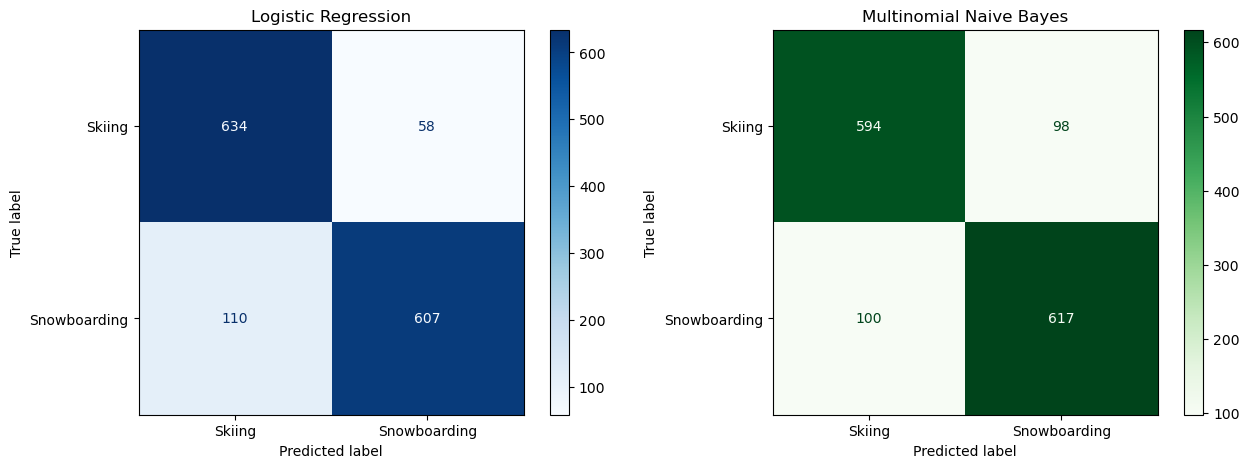

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ConfusionMatrixDisplay.from_predictions(y_test, preds_log_r, display_labels = ['Skiing', 'Snowboarding'], cmap = 'Blues', ax=ax[0]);
ConfusionMatrixDisplay.from_predictions(y_test, preds_nb_r, display_labels = ['Skiing', 'Snowboarding'], cmap = 'Greens', ax=ax[1]);

ax[0].set_title('Logistic Regression')
ax[1].set_title('Multinomial Naive Bayes');

In [80]:
print(f'\n---------------------- Logistic ---------------------- \n {classification_report(y_test, preds_log_r, digits=4)} \n')
print(f'------------------------- NB ------------------------- \n  {classification_report(y_test, preds_nb_r, digits=4)}')


---------------------- Logistic ---------------------- 
               precision    recall  f1-score   support

           0     0.8522    0.9162    0.8830       692
           1     0.9128    0.8466    0.8784       717

    accuracy                         0.8808      1409
   macro avg     0.8825    0.8814    0.8807      1409
weighted avg     0.8830    0.8808    0.8807      1409
 

------------------------- NB ------------------------- 
                precision    recall  f1-score   support

           0     0.8559    0.8584    0.8571       692
           1     0.8629    0.8605    0.8617       717

    accuracy                         0.8595      1409
   macro avg     0.8594    0.8595    0.8594      1409
weighted avg     0.8595    0.8595    0.8595      1409



##### <span style = 'color: blue'> <u>**Outcomes and Comparison**</u>: </span>
- <span style = 'color: blue'>The logistic regression model best parameters, based on RandomSearchCV (n_iter = 10), included:</span>
    - <span style = 'color: blue'>TfidfVectorizer with no stopwords</span>
        - <span style = 'color: blue'>Max_features = 9000</span>
        - <span style = 'color: blue'>C = 6.45 (inverse of regularization strength)</span>
    - <span style = 'color: blue'>Penalty = L2</span>
- <span style = 'color: blue'>The Bayes model best parameters, based on RandomSearchCV (n_iter = 10), included:</span>
    - <span style = 'color: blue'>CountVectorizer with no stopwords</span>
        - <span style = 'color: blue'>Max_features = 7000</span>
        - <span style = 'color: blue'>Max_df = 0.9</span>
    - <span style = 'color: blue'>Alpha = 1.0 (smoothing)</span>
    <br></br>
- <span style = 'color: blue'>**Logistic Regression** performed better than Multinomial Naive Bayes.</span>
    - <span style = 'color: blue'>The logistic regression had a higher testing **accuracy** score (**88.1%** vs. 86.0%), higher **precision** (**91.3%** vs. 86.3%), lower **sensitivity** (**84.7%** vs. 86.1%) and higher **specificity** (**91.6%** vs. 85.8%). </span>
    - <span style = 'color: blue'>Logistic regression predicted more false negatives (classified-skiers who were actually snowboarders) than Bayes, however, Bayes had more false positives (classified-snowboarded who were actually skiers). </span>
    
##### <span style = 'color: blue'>The next model will be compared to the logistic regression model.</span>

In [ ]:
# Precision: Out of all the messages that the model predicted would be spam, 98.8% were actually spam.
# Recall: Out of all the messages that were actually spam, the model predicted this outcome correctly 88.7% of the time.
# Specificity: Out of all the messages that were actually legitimate, our model predicted this outcome correctly 99.5% of the time (Tip: This is the recall of the negative class).

#### Model 3: Support Vector Machine

In [26]:
pipe_svc = Pipeline([
    ('vec', None),
    ('svc', SVC())
])

In [27]:
pgrid_svc =[
    {
    'vec': [CountVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 9000], 
    'vec__max_df': [0.9, 0.95],
     'svc__C': np.linspace(0.8, 1.1, 10),
     'svc__kernel': ['rbf','poly'],
     'svc__degree' : [2],
     'svc__tol' : [0.001]
    },
    {
    'vec': [TfidfVectorizer()],
    'vec__stop_words': [None, 'english'],
    'vec__max_features': [7000, 9000], 
    'vec__max_df': [0.9, 0.95],
     'svc__C': np.linspace(0.8, 1.1, 10),
     'svc__kernel': ['rbf','poly'],
     'svc__degree' : [2],
     'svc__tol' : [0.001]
    }
]

In [28]:
%%time

gs_svc = GridSearchCV(pipe_svc, pgrid_svc)
gs_svc.fit(X_train, y_train)

CPU times: total: 6min 34s
Wall time: 54min 23s


GridSearchCV(estimator=Pipeline(steps=[('vec', None), ('svc', SVC())]),
             param_grid=[{'svc__C': array([0.8       , 0.83333333, 0.86666667, 0.9       , 0.93333333,
       0.96666667, 1.        , 1.03333333, 1.06666667, 1.1       ]),
                          'svc__degree': [2], 'svc__kernel': ['rbf', 'poly'],
                          'svc__tol': [0.001], 'vec': [CountVectorizer()],
                          'vec__max_df': [0.9, 0.95],
                          'vec__max_features': [7000, 9000],
                          'vec__stop_words': [None, 'english']},
                         {'svc__C': array([0.8       , 0.83333333, 0.86666667, 0.9       , 0.93333333,
       0.96666667, 1.        , 1.03333333, 1.06666667, 1.1       ]),
                          'svc__degree': [2], 'svc__kernel': ['rbf', 'poly'],
                          'svc__tol': [0.001],
                          'vec': [TfidfVectorizer(max_df=0.9, max_features=7000,
                                                  stop_words='english')],
                          'vec__max_df': [0.9, 0.95],
                          'vec__max_features': [7000, 9000],
                          'vec__stop_words': [None, 'english']}])

In [70]:
# Make predictions for Accuracy Report
preds_svc = gs_svc.predict(X_test)

In [69]:
print(f'----------------- SVM w/ GridSearch -----------------')
print(f'------------- Train: {gs_svc.score(X_train, y_train)} -------------')
print(f'------------- Test: {gs_svc.score(X_test, y_test)} --------------')
print('Best Params:', gs_svc.best_params_)

----------------- SVM w/ GridSearch -----------------
------------- Train: 0.9865152590489709 -------------
------------- Test: 0.8757984386089425 --------------
Best Params: {'svc__C': 1.0333333333333334, 'svc__degree': 2, 'svc__kernel': 'rbf', 'svc__tol': 0.001, 'vec': TfidfVectorizer(max_df=0.9, max_features=7000, stop_words='english'), 'vec__max_df': 0.9, 'vec__max_features': 7000, 'vec__stop_words': 'english'}


In [104]:
%%time

# Test RandomizedSearch for comparison in timing and outcome
rs_svc = RandomizedSearchCV(pipe_svc, pgrid_svc, cv=5, n_iter=10, random_state=1527)
rs_svc.fit(X_train, y_train)

CPU times: total: 13.9 s
Wall time: 1min 26s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vec', None), ('svc', SVC())]),
                   param_distributions=[{'svc__C': array([0.8       , 0.83333333, 0.86666667, 0.9       , 0.93333333,
       0.96666667, 1.        , 1.03333333, 1.06666667, 1.1       ]),
                                         'svc__degree': [2],
                                         'svc__kernel': ['rbf', 'poly'],
                                         'svc__tol': [0.001],
                                         'vec': [CountVectorizer()],
                                         'vec__max_df': [0.9, 0.95],
                                         'vec__max_features': [7000, 9000],
                                         '...
                                        {'svc__C': array([0.8       , 0.83333333, 0.86666667, 0.9       , 0.93333333,
       0.96666667, 1.        , 1.03333333, 1.06666667, 1.1       ]),
                                         'svc__degree': [2],
                                         'svc__kernel': ['rbf', 'poly'],
                                         'svc__tol': [0.001],
                                         'vec': [TfidfVectorizer(max_df=0.9,
                                                                 max_features=7000,
                                                                 stop_words='english')],
                                         'vec__max_df': [0.9, 0.95],
                                         'vec__max_features': [7000, 9000],
                                         'vec__stop_words': [None, 'english']}],
                   random_state=1527)

In [105]:
# Make predictions for Accuracy Report
preds_svc_r = rs_svc.predict(X_test)

In [106]:
print(f'-------------- SVM w/ RandomizedSearch --------------')
print(f'------------- Train: {rs_svc.score(X_train, y_train)} -------------')
print(f'------------- Test: {rs_svc.score(X_test, y_test)} --------------')
print('Best Params:', rs_svc.best_params_)

# Randomized search computed faster and test score is slightly better - we will utilize RS more

-------------- SVM w/ RandomizedSearch --------------
------------- Train: 0.9874615566595695 -------------
------------- Test: 0.8772178850248403 --------------
Best Params: {'vec__stop_words': 'english', 'vec__max_features': 7000, 'vec__max_df': 0.9, 'vec': TfidfVectorizer(max_df=0.9, max_features=7000, stop_words='english'), 'svc__tol': 0.001, 'svc__kernel': 'rbf', 'svc__degree': 2, 'svc__C': 1.0666666666666669}


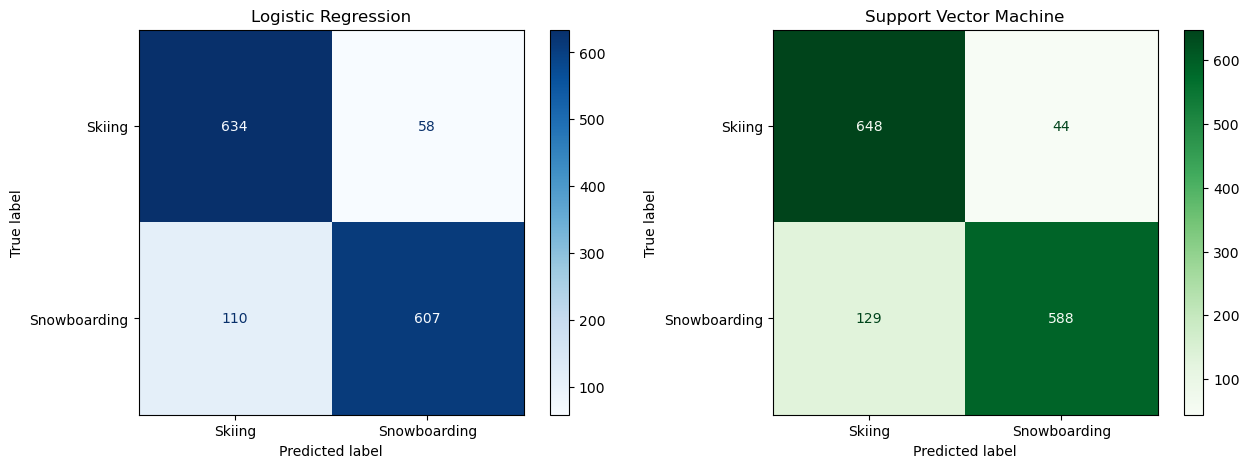

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ConfusionMatrixDisplay.from_predictions(y_test, preds_log_r, display_labels = ['Skiing', 'Snowboarding'], cmap = 'Blues', ax=ax[0]);
ConfusionMatrixDisplay.from_predictions(y_test, preds_svc_r, display_labels = ['Skiing', 'Snowboarding'], cmap = 'Greens', ax=ax[1]);

ax[0].set_title('Logistic Regression')
ax[1].set_title('Support Vector Machine');

In [84]:
print(f'\n---------------------- Logistic ---------------------- \n {classification_report(y_test, preds_log_r, digits=4)} \n')
print(f'------------------------- SVM ------------------------- \n  {classification_report(y_test, preds_svc_r, digits=4)}')


---------------------- Logistic ---------------------- 
               precision    recall  f1-score   support

           0     0.8522    0.9162    0.8830       692
           1     0.9128    0.8466    0.8784       717

    accuracy                         0.8808      1409
   macro avg     0.8825    0.8814    0.8807      1409
weighted avg     0.8830    0.8808    0.8807      1409
 

------------------------- SVM ------------------------- 
                precision    recall  f1-score   support

           0     0.8340    0.9364    0.8822       692
           1     0.9304    0.8201    0.8718       717

    accuracy                         0.8772      1409
   macro avg     0.8822    0.8782    0.8770      1409
weighted avg     0.8830    0.8772    0.8769      1409



##### <span style = 'color: blue'> <u>**Outcomes and Comparison**</u>:_ </span>
- <span style = 'color: blue'>The SVM model best parameters, based on RandomSearchCV (n_iter = 10), included:_</span>
    - <span style = 'color: blue'>TfidfVectorizer with English stopwords</span>
        - <span style = 'color: blue'>Max_features = 7000</span>
        - <span style = 'color: blue'>Max_df = 0.9</span>
    - <span style = 'color: blue'>Kernel = RBF (Radial Basis Function)</span>
    - <span style = 'color: blue'>C = 1.067 (inverse of regularization strength)</span>
    - <span style = 'color: blue'>Degree = 2_</span>   
- <span style = 'color: blue'>The logistic regression model best parameters, based on RandomSearchCV (n_iter = 10), included:</span>
    - <span style = 'color: blue'>TfidfVectorizer with no stopwords</span>
        - _<span style = 'color: blue'>Max_features = 9000_</span>
        - <span style = 'color: blue'>C = 6.45 (inverse of regularization strength)</span>
    - <span style = 'color: blue'>Penalty = L2</span>
    <br></br>
- <span style = 'color: blue'>**Logistic Regression** performed very slightly better than the Support Vector Machine.</span>
    - <span style = 'color: blue'>The logistic regression had a higher testing **accuracy** score (**88.1%** vs. 87.7%), lower **precision** (**91.3%** vs. 93.0%), higher **sensitivity** (**84.7%** vs. 82.0%) and lower **specificity** (**91.6%** vs. 93.6%). </span>

#### Model 4: Random Forest
##### This model will be addressing overfitting. All three models that have been fit have higher training scores than testing scores by ~4-10%:
- Logistic Regression
    - Train = 0.9744
    - Test = 0.8808
- Multinomial Naive Bayes
    - Train = 0.9025
    - Test = 0.8595
- Support Vector Machine
    - Train = 0.9875
    - Test = 0.8772
    
##### We will use Random Forest Classifier to ameliorate this impact and improve our model.

_Each of the three fitted models have higher training scores than testing scores by ~4-10% (Log: Train = 0.9744, Test = 0.8808; MNB: Train = 0.9025, Test = 0.8595, SVM: Train = 0.9875, Test = 0.8772). We will use Random Forest Classifier to ameliorate this impact and improve our model._